In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# from skimage.metrics import structural_similarity as ssim


# Load the image
image = cv2.imread("./images/cards2/photo_2023-07-07_13-55-25.jpg")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply adaptive thresholding to binarize the image
plt.imshow(gray, cmap="gray")


In [458]:
def plotter(img_list, r, w, gray, wr, hr, fig_name = None):
    '''
    Plots images' list with its' caption and saves result image if you want.

    Parameters:
        img_list (list): The list of tuples of image and its' caption.
        r (int): The number of row(s).
        w (int): The number of colunm(s).
        gray (bool): The flag for plotting images in grayscale mode.
        wr (int): The width of one figure.
        hr (int): The height of one figure.
        fig_name (str): The name of the image of the plot. if not set this parameter the plot doesn't save.
    '''
    
    plt.rcParams['figure.figsize'] = (wr, hr)
    for i in range(len(img_list)):
        plt.subplot(r, w, i + 1)
        if img_list[i][2] == 'img':
            if gray:
                plt.imshow(img_list[i][0], cmap = 'gray')
            else:
                plt.imshow(img_list[i][0])
            plt.xticks([])
            plt.yticks([])
        elif img_list[i][2] == 'hist':
            plt.bar(np.arange(len(img_list[i][0])), img_list[i][0], color = 'c')
        else:
            raise Exception("Only image or histogram. Use third parameter of tuples in img_list and set it to img or hist.")
        plt.title(img_list[i][1])
    if fig_name is not None:
        plt.savefig(fig_name + '.png')
    plt.show()

In [ ]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)
plt.imshow(thresh, cmap= "gray")
cv2.imwrite("Thresh.jpg", thresh)

In [ ]:
# Apply morphological operations to remove noise and fill gaps
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening, cmap= "gray")


In [ ]:
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(closing, cmap= "gray")

In [462]:
# plt.imshow(kernel)
# Find the contours of the document
contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [463]:
# Sort the contours by area and keep only the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
# plt.imshow(contours)


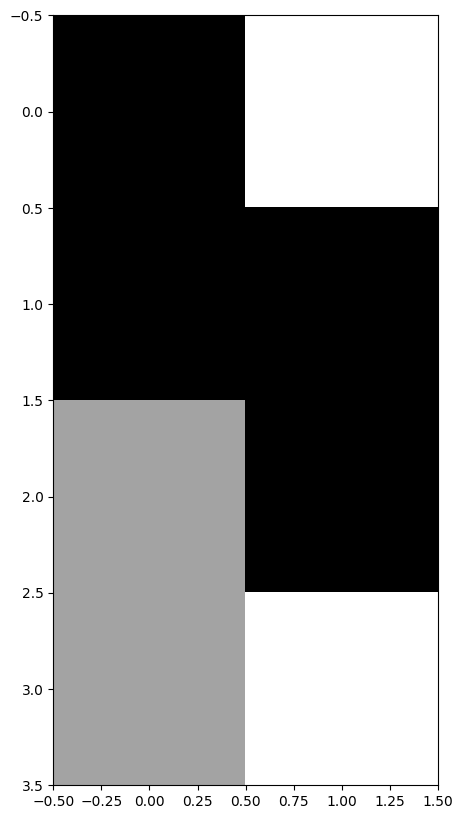

In [464]:
# Apply perspective transformation to "straighten" the image
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = np.int0(box)
width = int(rect[1][0])
height = int(rect[1][1])
src_pts = box.astype("float32")
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
plt.imshow(dst_pts, cmap= "gray")
M = cv2.getPerspectiveTransform(src_pts, dst_pts)


In [ ]:
warped = cv2.warpPerspective(image, M, (width, height))
if warped.shape[0]>warped.shape[1]:
    warped=cv2.rotate(warped,cv2.ROTATE_90_CLOCKWISE)
plt.imshow(warped, cmap= "gray")

In [ ]:
# Apply image enhancement techniques to improve quality
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap= "gray")


In [ ]:
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blurred, cmap= "gray")


In [ ]:
sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
plt.imshow(sharpened, cmap= "gray")

In [ ]:
denoised = cv2.fastNlMeansDenoising(sharpened, None, 10, 7, 21)
plt.imshow(denoised, cmap= "gray")

In [ ]:
# Save the resulting image
plt.imshow(denoised, cmap= "gray")
cv2.imwrite("output.jpg", denoised)

In [ ]:
result=cv2.adaptiveThreshold(denoised,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,10)
plt.imshow(result, cmap= "gray")

In [472]:
# You need to choose 4 or 8 for connectivity type
connectivity = 4 
# Perform the operation
output = cv2.connectedComponentsWithStats(result, connectivity, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output


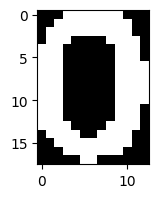

In [473]:
templates=[]
image_list=[]
connectivity=8
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
for i in range(10):
    img1=cv2.imread(f"./templates/{i}.png",cv2.IMREAD_GRAYSCALE)
    img2=cv2.imread(f"./templates2/{i}.png",cv2.IMREAD_GRAYSCALE)
    for temp in [img1,img2]:
        temp=cv2.threshold(temp,128,255,cv2.THRESH_BINARY_INV)[1]
        erode = cv2.morphologyEx(temp, cv2.MORPH_ERODE, kernel, iterations=1)
        dilate=cv2.morphologyEx(temp, cv2.MORPH_DILATE, kernel, iterations=1)
        for t in [temp,erode,dilate]:
            (numLabels_t, labels_t, stats_t, centroids_t)=cv2.connectedComponentsWithStats(t, connectivity, cv2.CV_32S)
            (x,y,w,h,a)=stats_t[1]
            templates.append(t[y:y+h,x:x+w])
            image_list.append([t[y:y+h,x:x+w],f"{i}","img"])
plt.figure(figsize=(2,2))
plt.imshow(templates[0], cmap= "gray")

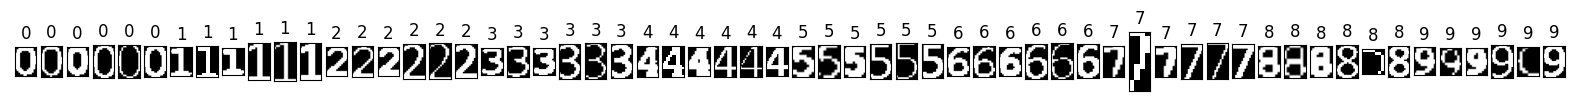

In [474]:
plotter(image_list,1 , 60, True, 20, 10)

In [ ]:
# stats = sorted(stats, key=lambda stat: stat[1])
components = []
output = result.copy()
warped_copy = warped.copy()
area = result.shape[0] * result.shape[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
for stat in stats:
    (x, y, w, h, a) = stat
    if a > area/100:
        continue
    if w < 5 or h < 5:
        continue
    done=False
    values=[]
    labels=[]
    for num in range(len(templates)):
        temp = templates[num].copy()
        # TODO: for augmentation of temp
        # if temp.shape[0]<h or temp.shape[1]<w:
        temp = cv2.resize(temp, (w, h), interpolation=cv2.INTER_AREA)
        crop=result[y:y+h, x:x+w].copy()
        crop = cv2.morphologyEx(crop, cv2.MORPH_DILATE, kernel, iterations=1)
        res = cv2.matchTemplate(
            crop, temp, cv2.TM_CCOEFF_NORMED)
        values.append(res[0,0])
        labels.append(num //6)
    threshold = 0.4
    index=np.argmax(values)
    if(values[index]<threshold):
        continue
    # loc = np.where(res >= threshold)
    # for pt in zip(*loc[::-1]):
    cv2.rectangle(warped_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
    components.append({
        "x": x, "y": y, "w": w, "h": h, "n": labels[index]})  # x,y,w,h,num (label)
        # break
            
plt.imshow(warped_copy, "gray")


In [476]:
#sort
threshold_y=15
threshold_x=40
lenn = len(components)
for i in range(lenn):
    for j in range(i + 1, lenn):
        if components[i]["y"] > components[j]["y"] + threshold_y:
            components[i], components[j] = components[j], components[i]
        elif components[j]["y"] > components[i]["y"] + threshold_y:
            pass
        elif components[i]["x"] > components[j]["x"]:
            components[i], components[j] = components[j], components[i]

In [ ]:
numbers=[f"{components[0]['n']}"]

for i in range(1,len(components)):
    last=components[i-1]
    comp=components[i]
    if abs(comp["y"]-last["y"])<threshold_y:
        if abs(comp["x"]-last["x"])<threshold_x:
            numbers[-1]+=f"{comp['n']}"
        else:
            numbers.append(f"{comp['n']}")
    else:
        numbers.append(f"{comp['n']}")
print(numbers)
mark=0
for num in numbers:
    n=len(num)
    if n>20:
        if n==25:
            print(f"shaba:IR{num[1:]}")
        else:
            print(f"shaba:IR{num}")
    elif n>14:
        print(f"card:{num[0:4]}-{num[4:8]}-{num[8:12]}-{num[12:16]}")
        mark=1
    elif n==7 or n==6 or n==5:
        print(f"expire:{num[:n-3]}/{num[n-2:]}")
    elif mark==1 and (n==4 or n==3):
        print(f"cvv{num}")
    
    

In [478]:

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [479]:
print(f'x_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_test : {y_test.shape}')

x_train : (60000, 28, 28)
y_train : (60000,)
x_test : (10000, 28, 28)
y_test : (10000,)


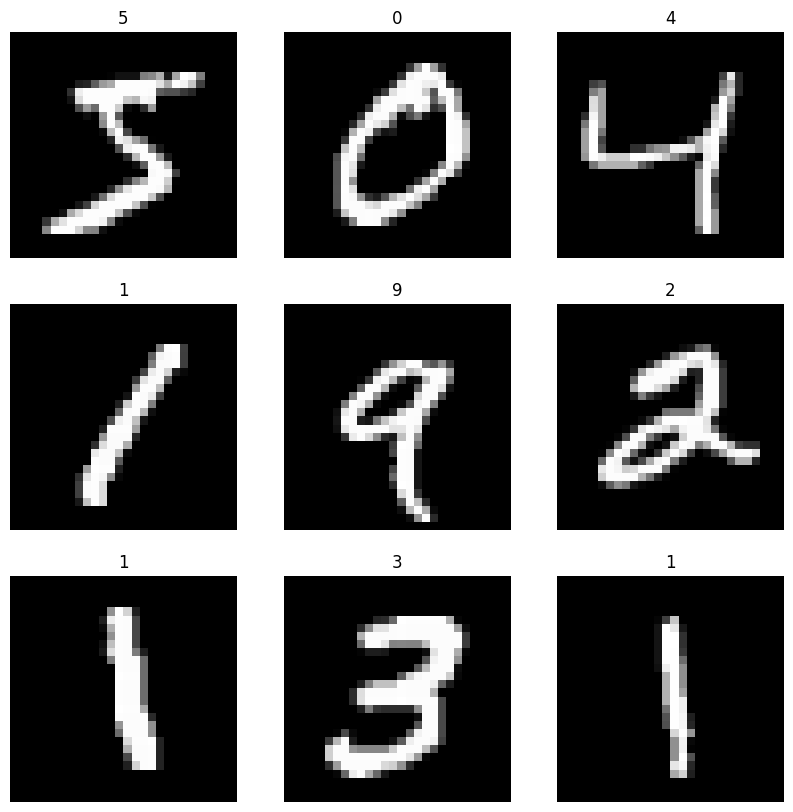

In [480]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i].astype("uint8"),cmap='gray')
    plt.title(y_train[i])
    plt.axis("off")

In [481]:
print(f'y_train[0]: {y_train[0]}')

y_train[0]: 5


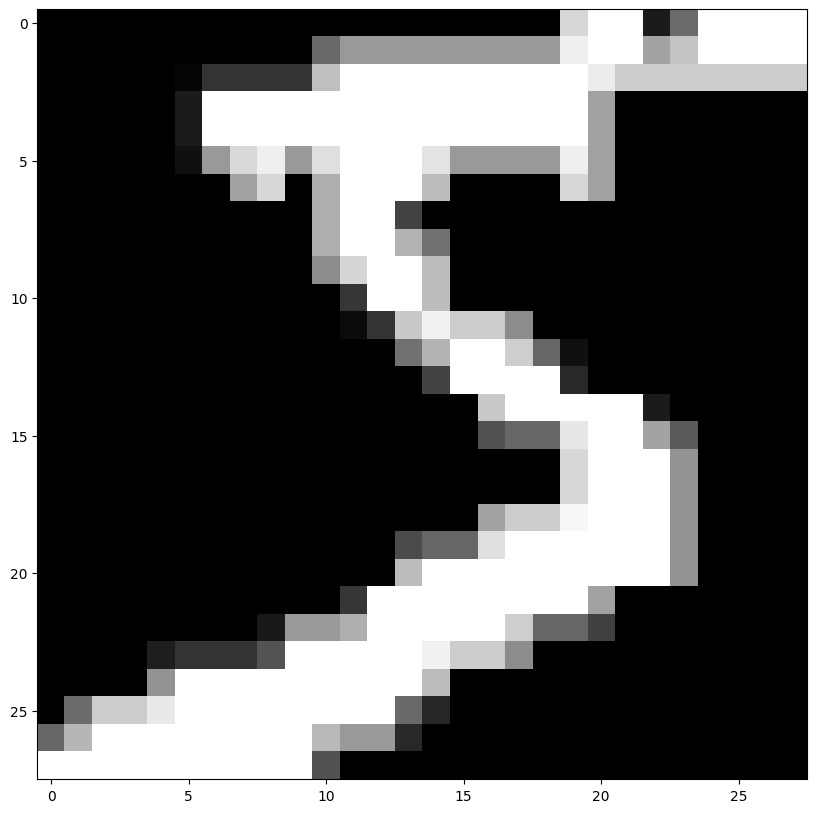

In [482]:
for i in range(len(x_train)):
    t=x_train[i]
    t=cv2.threshold(t,128,255,cv2.THRESH_BINARY)[1]
    
    (numLabels_t,labels_t, stats_t, centroids_t)=cv2.connectedComponentsWithStats(t, connectivity, cv2.CV_32S)
    (x,y,w,h,a)=stats_t[1]
    x_train[i]=cv2.resize(t[y:y+h,x:x+w], (28, 28), interpolation=cv2.INTER_AREA)
    if i==0:
        plt.imshow(x_train[i],"gray")
for i in range(len(x_test)):
    t=x_test[i]
    t=cv2.threshold(t,128,255,cv2.THRESH_BINARY)[1]
    (numLabels_t,labels_t, stats_t, centroids_t)=cv2.connectedComponentsWithStats(t, connectivity, cv2.CV_8U)
    (x,y,w,h,a)=stats_t[1]
    x_test[i]=cv2.resize(t[y:y+h,x:x+w], (28, 28), interpolation=cv2.INTER_AREA)
x_train = x_train/ 255.0
x_test = x_test / 255.0
x_train=x_train.reshape(-1, 28, 28, 1)
x_test=x_test.reshape(-1, 28, 28, 1)

In [483]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape,Softmax
from keras.models import Model, load_model,Sequential
import os
loaded=False
if os.path.isfile("model.h5"):
    seq_model= load_model('model.h5')
    loaded=True
else:
    seq_model = Sequential()
    seq_model.add(Input(shape= (28,28)))
    seq_model.add(Flatten())
    seq_model.add(Dense(units=128, activation='relu'))
    seq_model.add(Dense(units=10))

In [484]:
seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [485]:
if not loaded:
    seq_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [486]:
if not loaded:
    history = seq_model.fit(x_train, y_train, epochs=10)

In [487]:
import os
if not os.path.isfile("model.h5"):
    seq_model.save("model.h5")

In [488]:
if not loaded:
    plt.plot(history.history['loss'])
    plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.show()

In [489]:
test_loss, test_acc = seq_model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.1662 - accuracy: 0.9602 - 619ms/epoch - 2ms/step

Test accuracy: 0.9602000117301941


In [490]:
probability_model = tf.keras.Sequential([seq_model, Softmax()])

In [491]:
y_pred = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


label : 7


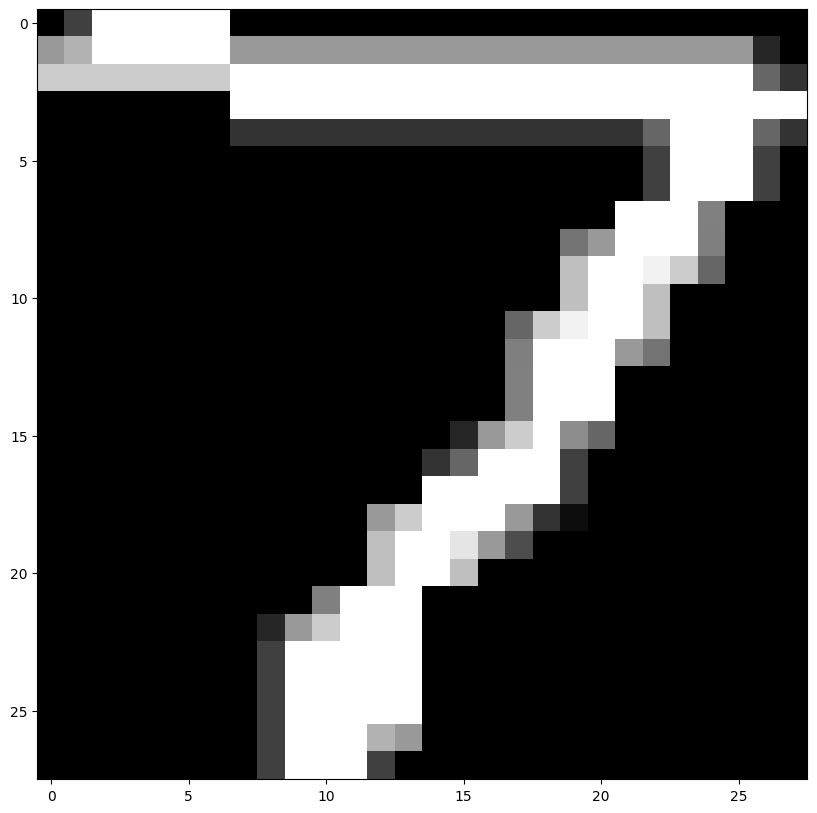

In [492]:
plt.imshow(x_test[0],cmap='gray')
label = np.argmax(y_pred[0])
print(f'label : {label}')

In [ ]:
components = []
output = result.copy()
warped_copy = warped.copy()
area = result.shape[0] * result.shape[1]
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
for stat in stats:
    (x, y, w, h, a) = stat
    if a > area/500:
        continue
    if w < 5 or h < 5:
        continue
    done=False
    crop=result[y:y+h, x:x+w].copy()
    crop=cv2.resize(crop, (28, 28), interpolation=cv2.INTER_AREA).reshape(-1, 28, 28, 1)
    pred_res=seq_model.predict(crop,verbose=0)
    threshold=700
    if(np.max(pred_res)<threshold):
        continue
    label_res=probability_model.predict(crop,verbose=0)[0]
    cv2.rectangle(warped_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)
    components.append({
        "x": x, "y": y, "w": w, "h": h, "n": np.argmax(label_res)})  # x,y,w,h,num (label)
plt.imshow(warped_copy)
        # break

In [494]:

threshold_y=15
threshold_x=80
lenn = len(components)
for i in range(lenn):
    for j in range(i + 1, lenn):
        if components[i]["y"] > components[j]["y"] + threshold_y:
            components[i], components[j] = components[j], components[i]
        elif components[j]["y"] > components[i]["y"] + threshold_y:
            pass
        elif components[i]["x"] > components[j]["x"]:
            components[i], components[j] = components[j], components[i]

In [495]:
numbers=[f"{components[0]['n']}"]

for i in range(1,len(components)):
    last=components[i-1]
    comp=components[i]
    if abs(comp["y"]-last["y"])<threshold_y:
        if abs(comp["x"]-last["x"])<threshold_x:
            numbers[-1]+=f"{comp['n']}"
        else:
            numbers.append(f"{comp['n']}")
    else:
        numbers.append(f"{comp['n']}")
print(numbers)
mark=0
for num in numbers:
    n=len(num)
    if n>20:
        if n==26:
            print(f"shaba:IR{num[2:]}")
        elif n==25:
            print(f"shaba:IR{num[1:]}")
        else:
            print(f"shaba:IR{num}")
        mark=1
    elif n>14:
        print(f"card:{num[0:4]}-{num[4:8]}-{num[8:12]}-{num[12:16]}")
        
    elif n==7 or n==6 or n==5:
        print(f"expire:{num[:n-3]}/{num[n-2:]}")
    elif mark==1 and (n==4 or n==3):
        print(f"cvv{num}")
    

['4', '81', '415', '44', '023', '389105402233470010613796908', '6221061224301634', '2739', '8', '1', '16', '22010642', '2']
shaba:IR389105402233470010613796908
card:6221-0612-2430-1634
cvv2739
